# Google Hackathon: 온실가스가 환경에 미치는 영향 분석 및 앱 개발

**Business Case**

- 이 프로젝트는 미국인들의 기후변화 회의론을 극복하고 지속 가능한 행동을 촉진하기 위해, 다양한 환경 및 사회경제 데이터를 종합적으로 분석하여 지구 온난화에 기여하는 주요 오염물질과 이와 관련된 사회경제적 요인을 식별하는 것을 목표로 한다. 실제로, 14%의 미국인들이 기후 변화는 증거가 없으며 이를 통해, 오염물질과 사회경제적 조건 사이의 상관관계를 규명하고, 기후변화 회의론자들에게 설득력 있는 증거를 제시하며, 보다 강력한 환경 보호 전략을 개발하고자 한다. 이러한 데이터 기반의 통찰력은 정책 결정자들이 보다 효과적인 기후 정책을 수립하는 데 도움을 줄 뿐만 아니라, 대중의 인식을 높이고 행동 변화를 유도하는 데에도 기여할 것이다. 또한, 재활용을 촉진하는 아나바다 앱과 연계하여 실질적인 환경 개선 효과를 기대하며, 궁극적으로 글로벌 기후변화 대응 노력을 지원하는 것이 이 프로젝트의 핵심이다.

**연구 질문**
- *지구 온난화에 가장 크게 기여하는 오염물질은 무엇이며, 이와 관련된 사회경제적 요인은 무엇인가?*

**연구 목표**
- 지구 온난화에 기여하는 주요 오염물질 식별
- 오염물질 배출과 관련된 사회경제적 요인 분석
- 기후변화 대응 전략 개발

### 구글 해커톤: 재활용 쓰레기 배출량이 이산화탄소 배출량에 미치는 영향 분석

이산화탄소는 지구 온난화의 주범이라고 널리 알려져 있다. 또한, 재활용률이 늘어나면 탄소 배출량 또한 줄어들 것이라는 것도 널리 알려져 있는 지식이다. 이 정보가 맞는 정보인지, 그리고 미국은 정말로 재활용률의 개선이 필요한 나라일지 데이터 분석을 통해 확인해본다.

In [ ]:
# 필요한 패키지 설치
# python 코드 포메터 라이브러리입니다. 필요하신분은 한번만 설치후 '%%pycodestyle'을 셀 위에 복붙하고 쓰시면 됩니다!
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic

ERROR: Operation cancelled by user
  Using cached pycodestyle-2.12.1-py2.py3-none-any.whl.metadata (4.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.0 MB/s eta 0:00:00
Using cached pycodestyle-2.12.1-py2.py3-none-any.whl (31 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.5 MB/s eta 0:00:00


ModuleNotFoundError: No module named 'pycodestyle_magic'

In [ ]:
# pycaret으로 모델 설치
!pip install pycaret

# lightgbm 모델 설치
!pip install lightgbm

In [ ]:
# 필요한 라이브러리 불러오기
import pandas as pd
import random
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LassoCV, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import PredictionError, ResidualsPlot
from pycaret.regression import setup, compare_models, pull, create_model, \
                               tune_model, predict_model
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import ttest_ind

In [ ]:
# Working in Google Colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Change Directory within Google Drive
os.chdir("/content/drive/MyDrive/아나바다/Data")

## 데이터 전처리 및 병합

In [ ]:
# 데이터를 먼저 파악해본다.
# Waste Data 불러오기
data = pd.read_csv("OECD_Waste_Data.csv")
data

In [ ]:
# 쓰레기 데이터 국가 이름 파악
data['Reference area'].unique()

In [ ]:
# CO2 Data 불러오기
co2_data = pd.read_csv('CO2_Data.csv')
co2_data

In [ ]:
# 쓰레기 데이터 국가 이름 파악
co2_data['country'].unique()

In [ ]:
# 데이터 별 국가의 이름이 서로 다른 것 같다. (예: Korea -> South Korea).
# 따라서 이름에 매핑이 필요한 것 같다.
# 이름 매핑 딕셔너리 생성
name_mapping = {
    'Czechia': 'Czech Republic',
    'Korea': 'South Korea',
    'Türkiye': 'Turkey',
    'United States': 'USA',
    'United Kingdom': 'UK',
    'Schweiz': 'Switzerland',
    'Deutschland': 'Germany'
}

# 이름 변경
data['Reference area'] = data['Reference area'].replace(name_mapping)

In [ ]:
# 데이터 저장
data.to_csv("OECD_Waste_Data.csv", index=False)

In [ ]:
co2_data

In [ ]:
# CO2 데이터의 년도별로 다른 것을 한 컬럼으로 묶어준다.
co2_data = pd.melt(co2_data, id_vars=['country'], var_name='year',
                   value_name='co2_emission')

In [ ]:
# CO2 데이터도 나라 이름에 걸맞게 필터링을 진행해준다.
ls = ['Australia', 'Costa Rica', 'Spain', 'Greece', 'Netherlands', 'Sweden',
      'Switzerland', 'Germany', 'Hungary', 'Italy', 'Japan', 'South Korea',
      'New Zealand', 'Austria', 'Chile', 'France', 'Mexico', 'Norway',
      'Slovenia', 'Colombia', 'Czech Republic', 'Denmark', 'Belgium', 'Canada',
      'Luxembourg', 'Latvia', 'Portugal', 'Slovak Republic', 'USA', 'Iceland',
      'Israel', 'Poland', 'Turkey', 'Estonia', 'UK', 'Finland', 'Ireland',
      'Lithuania']
co2_data = co2_data[co2_data['country'].isin(ls) == True]
co2_data['country'].unique()

In [ ]:
# 데이터 타입 변환
co2_data = co2_data.astype({'year': 'int64', 'co2_emission': 'float'})

In [ ]:
# 데이터 저장
co2_data.to_csv('CO2_Data.csv', index=False)

In [ ]:
# 쓰레기 데이터 열 이름 재설정
df_waste = data.rename(columns={'Reference area' : 'country',
                                'TIME_PERIOD' : 'year'})
# 쓰레기 데이터와 Co2 데이터 병합
df_merged = pd.merge(df_waste, co2_data, on = ['country', 'year'],
                     how = "left")

In [ ]:
# 결측치 확인
df_merged.isna().sum()

In [ ]:
# 비어있는 열과 관련이 없어 보이는 열은 드랍하기로 결정했다.
columns_to_drop = ['Time period', 'Observation value', 'OBS_STATUS_2',
                'Observation status 2', 'OBS_STATUS_3', 'Observation status 3',
                'OBS_STATUS_4', 'Observation status 4', 'CONVERSION_TYPE',
                'Conversion type', 'BASE_PER', 'Base period', 'PRICE_BASE',
                'Price base']
df_merged = df_merged.drop(columns=columns_to_drop)

In [ ]:
# 데이터 저장
df_merged.to_csv('merged_df.csv', index=False)

## 데이터 EDA


In [ ]:
# 데이터 불러오기
df = pd.read_csv('merged_df.csv')
df

In [ ]:
# 분석에 필요할 것 같은 컬럼들만 분류
df = df[['REF_AREA','country','MEASURE', 'Measure', 'Unit of measure', 'year',
    'OBS_VALUE', 'Observation status', 'Unit multiplier', 'co2_emission']]
df

### Description of columns

- REF_AREA: 국가 코드

- country: 국가명

- MEASURE: 처리 방법
  - MUNICIPAL : 총 쓰레기 (Total waste generated)
  - DISPOSAL : 폐기물 쓰레기 (매각, 비에너지화 소각, 기타)
  - RECOVERY : 재활용 쓰레기 (재활용, 퇴비화, 에너지화 소각, 기타)


- Unit of Measure: 단위
  - Percentage of treated waste : 쓰레기로 처리된 비율
  - Tonnes : 실제 쓰레기 양 (톤)

- year: 관측연도

- OBS_VALUE:
  - 비율이랑 실제 관측량 섞여 있음

- Observation status: 상태
  - Estimated value (E): 예상치
  - Normal value (A): 정상값
  - Time series break (B): 시계열 중단?
  - Value imputed by a receiving agency (I): 이상치?
- Unit multipiler: 숫자 단위
  - Thousands일 시 OBS_VALUE = `Percentage of treated waste`
  - Units일 시 OBS_VALUE = `Tonnes`
- co2_emmission: 인당 이산화탄소 배출량


``` 소문자는 CO2, 대문자는 OECD 데이터의 칼럼이다```



### 가설 1: 미국이 다른 OECD 국가보다 이산화탄소 배출량이 높을 것이다.

요약: 대부분의 경우 USA의 배출량이 가장 높다. LUX만이 전체 년도에서 USA보다 높은 이산화탄소 배출량을 보였다. 그러나 바 그래프가 불완전한 모양이었기 때문에 완전히 신뢰하기는 어렵다.

In [ ]:
# 비교를 위해 나라 이름, 연도, co2_emmision만 남긴다.
df_co2 = df[['REF_AREA', 'country', 'year', 'co2_emission']]
df_co2.head(20)

In [ ]:
# Unit, measure, status 등등으로 중복값 너무 많으므로, 제거하기로 결정했다.
df_co2 = df_co2.drop_duplicates()
df_co2.sort_values(by=['REF_AREA', 'year']) # 잘 됐나 체크

같은 년도의 데이터가 존재하지 않는 것으로 파악되므로 중복은 없어진 것 같다.
38개국이 있기 때문에 6개 국가씩 미국과 비교한다.

In [ ]:
# 미국이랑 다른 나라를 나누기
usa_data = df_co2[df_co2['country'] == 'USA']
others = df_co2[df_co2['country'] != 'USA']['country'].unique()

# 그룹으로 묶음
country_group = [others[i:i+6] for i in range(0, len(others), 6)]
country_group

In [ ]:
# 그래프 그리기
for i, group in enumerate(country_group):
  plt.figure(figsize=(15, 6))

  # USA를 강조하기 위해 marker는 * 표시를 하여 그래프를 강조
  plt.plot(usa_data['year'], usa_data['co2_emission'], label='USA',
           marker='*', linewidth=2, color='red')

  # 컬러 파레트 설정
  colors = ['gray', 'green', 'pink', 'orange', 'purple', 'brown', 'blue']

  # 국가 수가 6의 배수가 아니고 랜덤으로 뽑아야 하기 때문에 random.sample을 사용한다.
  group_colors = random.sample(colors, len(group))

  # 나라, 색 같이 골라야 하니까 zip으로 묶어서 for loop을 돌린다.
  for country, color in zip(group, group_colors):
    country_data = df_co2[df_co2['country'] == country]
    plt.plot(country_data['year'], country_data['co2_emission'], label=country,
             marker='o', linewidth=2, color=color)

  plt.title(f'Co2 Emissions of USA and Group {i+1}')
  plt.xlabel('Year')
  plt.ylabel('Co2 Emission')
  plt.legend()

  plt.grid(True)

plt.show()

#### 결론
Switzerland. Belgium, Luxembourg 세 국가를 제외하고는 USA의 Co2 Emission이 가장 높은 것으로 파악된다. Co2 per Capita라는 특성상, 지리적으로 이산화탄소 배출량이 많은 국가고 인구 수가 적을 수록 수치가 높아진다. 스위스는 자국에서 에너지 자원을 많이 생산하지 않고 대부분의 에너지 자원을 수입에 의존하기 때문에 Co2 배출량이 높아지는 현상이 있다. 또한 Belgium의 경우 중공업이 발달된 국가이며 화석 연료를 주로 쓰는 국가이기에 이산화탄소 배출량이 높아진다. 마지막으로 Luxembourg는 인구 수가 매우 적은 국가로, 상대적으로 높게 측정되는 경향이 있다.

미국은 인구 수 3위를 기록하며 Co2 Emission Per Capita가 4번째로 가장 높게 나타난다는 것은 이산화탄소 배출량이 상당히 높다는 것으로 생각이 된다.

### 가설 2: 미국이 다른 OECD 국가보다 재활용 쓰레기 처리 비율이 낮을 것이다.

In [ ]:
# 미국의 재활용 쓰레기 비율을 알아보기 위해 데이터 전처리를 한다.
# 먼저 쓰레기 매립량, 재활용량, 전체 쓰레기량을 합산하여, 비율을 계산한다.

# Filter data where 'Unit of measure' is 'Tonnes'
data_tonnes = df[df['Unit of measure'] == 'Tonnes']

# Calculate the total disposal (including other disposal) for each country and year
landfill_operations = data_tonnes[data_tonnes['MEASURE'] == 'LANDFILL'] \
                      .groupby(['country', 'year'])['OBS_VALUE'].sum()

# Calculate the total recovery (including other recovery) for each country and year
recycling_operations = data_tonnes[data_tonnes['MEASURE'] == 'RECYCLING'] \
                      .groupby(['country', 'year'])['OBS_VALUE'].sum()

# Get total waste generated
total_waste_generated = data_tonnes[data_tonnes['MEASURE'] == 'MUNICIPAL'] \
                        .groupby(['country', 'year'])['OBS_VALUE'].sum()

# Convert series to dataframes
total_landfill_df = landfill_operations.reset_index(name='Total_Landfill')
total_recycling_df = recycling_operations.reset_index(name='Total_Recycling')
total_waste_generated_df = total_waste_generated \
                          .reset_index(name='Total_Waste_Generated')

# Merge the dataframes
analysis_df = pd.merge(total_waste_generated_df, total_landfill_df,
                       on=['country', 'year'], how='left')
analysis_df = pd.merge(analysis_df, total_recycling_df,
                       on=['country', 'year'], how='left')

# Calculate the disposal and recovery rates
analysis_df['Landfill_Rate'] = analysis_df['Total_Landfill'] / \
                               analysis_df['Total_Waste_Generated'] * 100
analysis_df['Recycling_Rate'] = analysis_df['Total_Recycling'] / \
                                analysis_df['Total_Waste_Generated'] * 100

# Display the result
analysis_df.head()

In [ ]:
# 쓰레기 매립률을 국가별로 시각화 한다. IpyWidgets으로 드롭다운 버튼을 만들어, 국가 별로 매립량을
# 볼 수 있도록 한다.

# Function to plot disposal rate for selected country
def plot_landfill_rate(country):
    country_data = analysis_df[analysis_df['country'] == country]
    plt.figure(figsize=(10, 5))
    plt.plot(country_data['year'], country_data['Landfill_Rate'], marker='o')
    plt.title(f'Landfill Rate Over Time for {country}')
    plt.xlabel('Year')
    plt.ylabel('Landfill Rate (%)')
    plt.grid(True)
    plt.show()

# Create dropdown for countries
countries = analysis_df['country'].unique()
dropdown = widgets.Dropdown(options=countries, description='Select Country:')

# Interaction between dropdown and plot function
widgets.interactive(plot_landfill_rate, country=dropdown)

In [ ]:
# 쓰레기 재활용률을 국가별로 시각화 한다. IpyWidgets으로 드롭다운 버튼을 만들어, 국가 별로 재활용률을
# 볼 수 있도록 한다.

# Function to plot disposal rate for selected country
def plot_recycling_rate(country):
    country_data = analysis_df[analysis_df['country'] == country]
    plt.figure(figsize=(10, 5))
    plt.plot(country_data['year'], country_data['Recycling_Rate'], marker='o')
    plt.title(f'Recycling Rate Over Time for {country}')
    plt.xlabel('Year')
    plt.ylabel('Recycling Rate (%)')
    plt.grid(True)
    plt.show()

# Create dropdown for countries
countries = analysis_df['country'].unique()
dropdown = widgets.Dropdown(options=countries, description='Select Country:')

# Interaction between dropdown and plot function
widgets.interactive(plot_recycling_rate, country=dropdown)

In [ ]:
# Filter the data for the selected countries and Landfill Rate measure
selected_countries = ['USA', 'Germany', 'Japan', 'UK', 'France', 'Italy',
                      'Mexico', 'Australia', 'South Korea', 'Spain']
filtered_data = analysis_df[(analysis_df['country'].isin(selected_countries))]

# Plotting the line graph using seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_data, x='year', y='Landfill_Rate', hue='country', marker='o', palette='tab10')

# Setting the labels and title
plt.xlabel('Year')
plt.ylabel('Landfill Rate')
plt.title('Landfill Rate Over Time for Selected Countries')
plt.legend(title='Country')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Plotting the line graph using seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_data, x='year', y='Recycling_Rate', hue='country', marker='o', palette='tab10')

# Setting the labels and title
plt.xlabel('Year')
plt.ylabel('Landfill Rate')
plt.title('Landfill Rate Over Time for Selected Countries')
plt.legend(title='Country')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# 쓰레기 매립률을 전체 국가와 비교해서 그래프를 만든다. 몇몇 국가는 100%나 아주 높은 매립률을
# 보여주는데, 이는 이상치나 재활용을 하기 어려운 나라로 판단된다.
def plot_landfill_rates():
    fig = px.line(analysis_df, x='year', y='Landfill_Rate', color='country',
                  title='Yearly Landfill Rates by Country',
                  labels={'Landfill_Rate': 'Landfill Rate (%)',
                          'year': 'Year'})
    fig.update_traces(mode='lines+markers')
    fig.show()

plot_landfill_rates()

In [ ]:
# 쓰레기 재활용률을 전체 국가와 비교해서 그래프를 만든다. 한국이 가장 높은 재활용률을 기록하고 있으며,
# 미국은 낮은 20%대의 재활용률을 기록 중이다.
def plot_recycling_rates():
    fig = px.line(analysis_df, x='year', y='Recycling_Rate', color='country',
                  title='Yearly Recycling Rates by Country',
                  labels={'Recycling_Rate': 'Recycling Rate (%)',
                          'year': 'Year'})
    fig.update_traces(mode='lines+markers')
    fig.show()

plot_recycling_rates()

In [ ]:
# 미국의 전체적인 지표 확인
analysis_df[analysis_df['country'] == 'USA']

#### 결론:
전체적인 지표로 확인 결과, 미국보다 낮은 재활용률을 기록한 나라나, 높은 매립률을 기록한 나라들은 존재한다. 하지만 OECD 국가 중 가장 많은 인구수를 가진 미국의 입장에서 고려한다면 미국의 재활용률과 매립률은 상당히 다른 나라의 비해 부족한 것으로 판단된다. 긍정적인 면은, 2005년 이후로 매립률과 재활용률이 상당히 개선되고 있지만, 2018년에는 쓰레기량이 늘어남과 동시에 다시 안 좋아지는 추세로 확인된다.

### 가설 3: 미국이 재활용 쓰레기 처리 비율이 낮을 때, 이산화탄소 배출량이 높을것이다.

In [ ]:
# 오리지널 데이터프레임과 쓰레기 비율을 계산한 데이터프레임을 병합한다.
dataset = pd.merge(df, analysis_df, on=['country', 'year'], how='left')
dataset

In [ ]:
# 병합한 데이터 저장
dataset.to_csv('corr_df.csv', index=False)

In [ ]:
# 미국으로 국가 필터링
usa_data = dataset[dataset['country'] == 'USA']

In [ ]:
# 미국의 열 이름 추출
numeric_list = usa_data.describe().columns
# 컬럼 별 상관관계를 계산하여 변수에 저장
corr_data = usa_data[numeric_list].corr()

In [ ]:
# 데이터 확인
corr_data

In [ ]:
# 상관관계 행렬 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Waste Variables and Co2 Emissions')
plt.show()

In [ ]:
# Median split for Recycling Rate
median_recycling_rate = corr_data['Recycling_Rate'].median()
high_recycling_group = corr_data[corr_data['Recycling_Rate'] >= \
                                 median_recycling_rate]['co2_emission']
low_recycling_group = corr_data[corr_data['Recycling_Rate'] < \
                                median_recycling_rate]['co2_emission']

# T-test for Recycling Rate groups
ttest_result_recycling = ttest_ind(high_recycling_group,
                                   low_recycling_group, equal_var=False)

# Median split for Landfill Rate
median_landfill_rate = corr_data['Landfill_Rate'].median()
high_landfill_group = corr_data[corr_data['Landfill_Rate'] >= \
                                median_landfill_rate]['co2_emission']
low_landfill_group = corr_data[corr_data['Landfill_Rate'] < \
                               median_landfill_rate]['co2_emission']

# T-test for Landfill Rate groups
ttest_result_landfill = ttest_ind(high_landfill_group,
                                  low_landfill_group, equal_var=False)

ttest_result_recycling, ttest_result_landfill

T-Test 결과, p-value가 둘다 < 0.05 이므로 높은 재활용률 집단과 낮은 재활용률 집단 간의 CO2 배출량에 통계적으로 유의미한 차이가 있음을 나타내고, 높은 매립률 집단과 낮은 매립률 집단 간의 CO2 배출량에 통계적으로 유의미한 차이가 존재한다는걸 시사한다.

#### 해석
- Recycling Rate: 높은 재활용률이 CO2 배출을 감소시키는 것과 관련이 있을 수 있음을 시사한다.
- Landfill Rate: 높은 매립률이 높은 CO2 배출과 관련이 있을 가능성을 나타낸다.

따라서 재활용률을 개선한다면 CO2 배출을 감소시킬 수 있을 것이라 보여진다. 이를 위해 아나바다 재활용 독려 앱 개발을 시작한다.

# 데이터 분석(해커톤 이후)

아나바다 앱 개발 이후, 미국인들의 기후변화 회의론에 대해 반박하기 위하여, 데이터 분석을 추가로 진행해보기로 결정하였다. 실제로, 14%의 미국인들이 기후 변화는 증거가 없다고 생각하며, 67%의 인구는 환경 과학자를 믿지 않는다고 한다. 이들을 설득하고 환경 보호 전략을 개발하기 위해 다양한 환경 및 사회 경제 데이터를 분석하고, 어떤 요인이 지구 온난화에 가장 기여를 하는 요인인지 분석을 진행해본다.

### 온도 Anomaly 시각화

Our Wolrd In Data에서 가져온 Average Temperature Anomaly 데이터로 시각화를 진행해본다.

In [ ]:
# Anomaly 데이터 불러오기
temp = pd.read_csv("temperature-anomaly.csv")
temp.head()

In [ ]:
#지역 별로 나누기
en_global = temp[temp['Entity']=='Global'].drop(columns={'Code'})
en_north = temp[temp['Entity']=='Northern hemisphere'].drop(columns={'Code'})
en_south = temp[temp['Entity']=='Southern hemisphere'].drop(columns={'Code'})

# 컬럼 이름 수정
en_global.rename(columns={'Global average temperature anomaly relative to 1961-1990':'average_temperature_anomaly'},
                          inplace=True)
en_north.rename(columns={'Global average temperature anomaly relative to 1961-1990':'average_temperature_anomaly'},
                          inplace=True)
en_south.rename(columns={'Global average temperature anomaly relative to 1961-1990':'average_temperature_anomaly'},
                          inplace=True)

In [ ]:
# 선 그래프를 사용하여 지역별 아노말리 데이터 시각화
fig, axs = plt.subplots(1,3, figsize=(20,5))
sns.lineplot(data=en_global,x='Year', y='average_temperature_anomaly',
             label='Global', ax=axs[0], color='green')
sns.lineplot(data=en_north,x='Year', y='average_temperature_anomaly',
             label='Northern Hemisphere',  ax=axs[1], color='red')
sns.lineplot(data=en_south,x='Year', y='average_temperature_anomaly',
             label='Southern Hemisphere', ax=axs[2], color='blue')

y_min, y_max = axs[0].get_ylim()

for ax in axs:
    ax.axhline(0, color='red', linestyle='--')
    ax.set_ylim(y_min, y_max)
    ax.legend(loc='upper left')

fig.suptitle('World Average Temperature Anomaly', fontsize=16)

In [ ]:
# 한 플롯 안에 선 그래프 시각화
plt.figure(figsize=(12,10))
plt.title('World Average Temperature Anomaly', fontsize=16)
plt.axhline(0, color='red', linestyle='--')
sns.lineplot(data=en_global, x='Year', y='average_temperature_anomaly',
             label='Global', color='green')
sns.lineplot(data=en_north, x='Year', y='average_temperature_anomaly',
             label='Northern Hemisphere', color='red')
sns.lineplot(data=en_south, x='Year', y='average_temperature_anomaly',
             label='Southern Hemisphere', color='blue')

plt.legend()

# 각 텍스트 위치 계산 (마지막 데이터 지점의 y값 가져오기)
last_value_global = en_global[en_global['Year'] == 2024]\
                             ['average_temperature_anomaly'].values[0]
last_value_north = en_north[en_north['Year'] == 2024]\
                           ['average_temperature_anomaly'].values[0]
last_value_south = en_south[en_south['Year'] == 2024]\
                           ['average_temperature_anomaly'].values[0]

# 텍스트 추가
plt.text(2025, last_value_global, 'Global', color='green',
         fontsize=12, va='center')
plt.text(2025, last_value_north, 'North', color='red',
         fontsize=12, va='center')
plt.text(2025, last_value_south, 'South', color='blue',
         fontsize=12, va='center')

#### 결과:
Average Temperature Anomaly란 1950~1980년대의 평균 온도를 0도로 하고, 연도 별 평균 온도가 기준점인 0도 보다 얼만큼 차이나는지를 보여주는 수치이다. 시각화로 본 결과, 전체적으로 온도가 시간이 갈 수록 상승하는 것으로 보여지며, 특히 **북쪽 국가**에서는 더 높게 온도가 상승하는 것으로 보여진다.

### Forest Area Visualization

In [ ]:
# forest 데이터 시각화 전 전처리
import pandas as pd
df = pd.read_csv('forest_area.csv')

In [ ]:
# forest area 평균 낸 후, 데이터 저장
df.groupby('Year')['Forest area'].mean().reset_index().to_csv('World_forest_area_mean.csv', index=False)

In [ ]:
# Checking info of forest dataset
df.info()

In [ ]:
# 국가별 산림면적 데이터를 시각화 하기 위해 국가 좌표 데이터도 불러온다.
# Reading country code csv file
country_coords = pd.read_csv('country-coord.csv')
country_coords

In [ ]:
# 국가 좌표 데이터 상 국가 이름과 산림 면적 데이터 안에 있는 국가 이름이 다른것들이 있으므로 확인 후
# 전처리 한다.
# Check for unique country names in both datasets to identify discrepancies
forest_countries = set(df['Entity'].unique())
coord_countries = set(country_coords['Country'].unique())

# Find discrepancies between the two datasets
missing_in_forest = coord_countries - forest_countries
missing_in_coord = forest_countries - coord_countries

missing_in_forest, missing_in_coord

In [ ]:
# 이름을 맵핑하여 통합한다. 대부분의 나라들의 이름은 통일하고, 세부적인 나라의 이름일 경우(예: World)
# 맵핑하지 않기로 결정하였다.
# Creating a mapping dictionary to correct country names in
# `forest_area_df` to match those in `country_coord_df`

name_mapping = {
    'Bolivia': 'Bolivia, Plurinational State of',
    'Czechia': 'Czech Republic',
    'Democratic Republic of Congo': 'Congo, the Democratic Republic of the',
    'Eswatini': 'Swaziland',
    'Iran': 'Iran, Islamic Republic of',
    'Laos': "Lao People's Democratic Republic",
    'Libya': 'Libyan Arab Jamahiriya',
    'Moldova': 'Moldova, Republic of',
    'North Korea': "Korea, Democratic People's Republic of",
    'South Korea': 'Korea, Republic of',
    'Russia': 'Russian Federation',
    'Syria': 'Syrian Arab Republic',
    'Tanzania': 'Tanzania, United Republic of',
    'East Timor': 'Timor-Leste',
    'Venezuela': 'Venezuela, Bolivarian Republic of',
    'Vietnam': 'Viet Nam',
    'Vatican': 'Holy See (Vatican City State)',
    'Taiwan': 'Taiwan, Province of China',
    'Macedonia': 'Macedonia, the former Yugoslav Republic of',
    'Palestine': 'Palestinian Territory, Occupied',
    'Micronesia': 'Micronesia, Federated States of',
    'Brunei': 'Brunei Darussalam',
    'Côte d\'Ivoire': "Côte d'Ivoire",
    'Falkland Islands': 'Falkland Islands (Malvinas)',
    'French Guyana': 'French Guiana',
    'U.S. Virgin Islands': 'Virgin Islands, U.S.',
    'British Virgin Islands': 'Virgin Islands, British',
    'Wallis and Futuna Islands': 'Wallis and Futuna'
}

# Apply the mapping to the forest_area_df
df['Entity'] = df['Entity'].replace(name_mapping)

# Check again for any discrepancies
forest_countries = set(df['Entity'].unique())
missing_in_forest = coord_countries - forest_countries
missing_in_coord = forest_countries - coord_countries

missing_in_forest, missing_in_coord

In [ ]:
# 국가 좌표 데이터와 산림 면적 데이터 병합
# Renaming columns to standardize them for merging
country_coords.rename(columns={"Country": "Entity",
                               "Alpha-3 code": "Iso_Alpha",
                               "Latitude (average)": "Latitude",
                               "Longitude (average)": "Longitude"},
                      inplace=True)

# Merging the forest area data with the country coordinates data
merged_data = pd.merge(df, country_coords[['Entity', "Iso_Alpha",'Latitude',
                                           'Longitude']],
                      on='Entity')

# Checking the merged data
merged_data.head()

In [ ]:
# 분석 리포트용: 전체 국가들의 전체 산림 면적 연도별 증감 트렌드 시각화
# Plotting the line graph using seaborn
plt.figure(figsize=(14, 8))
sns.regplot(data=df[df['Entity'] == 'World'], x='Year', y='Forest area',
             color='Green', marker='o')

# Setting the labels and title
plt.xlabel('Year')
plt.ylabel('Forest Area')
plt.title('World Forest Area Over Time')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# 산림 면적 지도 시각화
# Setting Custom Pastel tone green color
custom_green_colors = [
    "#F7FCF5", # 매우 연한 녹색
    "#D9F0D3", # 밝은 녹색
    "#A6DBA0", # 연한 녹색
    "#74C476", # 중간 녹색
    "#31A354", # 짙은 녹색
    "#006D2C", # 매우 짙은 녹색
    "#00441B"   # 거의 검은 녹색
]

# Drawing choropleth map of forest area
fig = fig = px.choropleth(
        merged_data,
        locations='Iso_Alpha',
        color='Forest area',
        hover_name='Entity',
        title='Global Forest Area From 1990 to 2020',
        projection='natural earth',
        animation_frame='Year',
        range_color=(0, 500000000.0),
        color_continuous_scale=custom_green_colors
    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### 결론:

세계 산림 면적 데이터를 시각화해본 결과, 전체적으로 산림면적이 빠르게 줄고 있는 것으로 확인 된다.

### Surface Temperature Visualization

In [ ]:
data = pd.read_csv("surface_temp_raw.csv")
data

In [ ]:
# Rename the original 'Year' column to 'Month' to avoid confusion
data.rename(columns={"Year": "Month"}, inplace=True)

# Melt the DataFrame to convert year columns into rows
melted_data = pd.melt(data, id_vars=["Entity", "Code", "Month"],
                      var_name="Year", value_name="Temperature")

# Convert the 'Year' column to numeric for proper sorting and processing
melted_data["Year"] = pd.to_numeric(melted_data["Year"])

In [ ]:
# Group by Entity, Code, and Year, then calculate the average temperature
# for each year
cleaned_data = melted_data.groupby(["Entity", "Code", "Year"])["Temperature"] \
                                  .mean().reset_index()

# Rename the 'Temperature' column to 'Avg_Temperature'
cleaned_data.rename(columns={"Temperature": "Avg_Temperature"}, inplace=True)

In [ ]:
cleaned_data.head()

In [ ]:
cleaned_data.to_csv("surface_temperature.csv", index=False)

In [ ]:
# 지구 표면 온도 시각화를 위해 표면 온도 데이터를 가져온다
surface = pd.read_csv('surface_temperature.csv')
surface

In [ ]:
# 1990년에서 2020년까지 필터링
surface = surface[(surface['Year'] >= 1990) & (surface['Year'] < 2020)]
surface

#### Surface Temperature w. Plotly

In [ ]:
# forest처럼 세계지도에 그려 보기 위해 위경도 있는 데이터 활용
country_coords = pd.read_csv('country-coord.csv')
country_coords

In [ ]:
# 국가 좌표 데이터 상 국가 이름과 산림 면적 데이터 안에 있는 국가 이름이 다른것들이 있으므로 확인 후
# 전처리 한다.
# Check for unique country names in both datasets to identify discrepancies
surface_countries = set(surface['Entity'].unique())
coord_countries = set(country_coords['Country'].unique())

# Find discrepancies between the two datasets
missing_in_surface = coord_countries - surface_countries
missing_in_coord = surface_countries - coord_countries

missing_in_surface, missing_in_coord

In [ ]:
# 이름을 맵핑하여 통합한다. 대부분의 나라들의 이름은 통일하고, 세부적인 나라의 이름일 경우(예: World)
# 맵핑하지 않기로 결정하였다.
replace_dict = {
    'Bolivia, Plurinational State of': 'Bolivia',
    'Brunei Darussalam': 'Brunei',
    "Côte d'Ivoire": "Cote d'Ivoire",
    'Czech Republic': 'Czechia',
    'Congo, the Democratic Republic of the': 'Democratic Republic of Congo',
    "Korea, Democratic People's Republic of": 'North Korea',
    'Korea, Republic of': 'South Korea',
    "Lao People's Democratic Republic": 'Laos',
    'Libyan Arab Jamahiriya': 'Libya',
    'Macedonia, the former Yugoslav Republic of': 'North Macedonia',
    'Moldova, Republic of': 'Moldova',
    'Russian Federation': 'Russia',
    'Syrian Arab Republic': 'Syria',
    'Taiwan, Province of China': 'Taiwan',
    'Tanzania, United Republic of': 'Tanzania',
    'Timor-Leste': 'East Timor',
    'Venezuela, Bolivarian Republic of': 'Venezuela',
    'Viet Nam': 'Vietnam',
    'Iran, Islamic Republic of': 'Iran',
    'Palestinian Territory, Occupied': 'Palestine',
    'Saint Helena, Ascension and Tristan da Cunha': 'Saint Helena',
    'Falkland Islands (Malvinas)': 'Falkland Islands',
    'Swaziland': 'Eswatini',
    'Holy See (Vatican City State)': 'Vatican City',
    'United States Virgin Islands': 'Virgin Islands, U.S.',
}

# 데이터셋의 국가 이름 변경
surface['Entity'] = surface['Entity'].replace(replace_dict)
country_coords['Country'] = country_coords['Country'].replace(replace_dict)

# 변경 후에도 여전히 불일치가 있는지 확인
surface_countries = set(surface['Entity'].unique())
coord_countries = set(country_coords['Country'].unique())

missing_in_surface = coord_countries - surface_countries
missing_in_coord = surface_countries - coord_countries

missing_in_surface, missing_in_coord

In [ ]:
# 이름을 통일한 후 데이터프레임을 병합한다.
# Renaming columns to standardize them for merging
country_coords.rename(columns={"Country": "Entity",
                               "Alpha-3 code": "Iso_Alpha",
                               "Latitude (average)": "Latitude",
                               "Longitude (average)": "Longitude"},
                      inplace=True)

# Merging the forest area data with the country coordinates data on the 'Entity' column
merged_data = pd.merge(surface, country_coords[['Entity', "Iso_Alpha",
                                                'Latitude', 'Longitude']],
                       on='Entity', how='left')

# Checking the merged data
merged_data.head()

In [ ]:
# 분석 리포트용: 전체 국가들의 전체 평균 표면 온도 연도별 증감 트렌드 시각화
# Plotting the line graph using seaborn
plt.figure(figsize=(14, 8))
sns.regplot(data=surface[surface['Entity'] == 'World'], x='Year',
            y='Avg_Temperature', color="#ff3d00", marker='o')

# Setting the labels and title
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.title('World Average Temperature Over Time')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
custom_red_yellow_colors = [
    "#FFFF00",  # Very light pastel yellow
    "#ffe8b5",  # Light pastel yellow
    "#ffd180",  # Soft yellow-orange
    "#ffab40",  # Medium pastel orange
    "#ff8c00",  # Darker orange
    "#ff5722",  # Soft red
    "#ff3d00",  # Bright red
    "#d50000"   # Dark red
]

fig = fig = px.choropleth(
        merged_data,
        locations='Iso_Alpha',
        color='Avg_Temperature',
        hover_name='Entity',
        title='Global Surafce Temperature From 1990 to 2020',
        projection='natural earth',
        animation_frame='Year',
        range_color=(0, 31),
        color_continuous_scale=custom_red_yellow_colors
    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### 국가별 온도 증감율

In [ ]:
# 온도 증감율을 국가별로 본다.
# 각 국가별로 데이터를 나눔
countries = merged_data['Entity'].unique()

# temp = merged_data['Avg_Temperature'].unique()
fig = go.Figure()

# 모든 국가의 각 Temperature에 대해 trace 추가
for country in countries:
  country_data = merged_data[merged_data['Entity'] == country]
  fig.add_trace(go.Scatter(
      x=country_data['Year'], y=country_data['Avg_Temperature'],
      mode='lines+markers', name=f'{country}',
      visible=False, # line=go.scatter.Line(color="gray"),
      showlegend=True,
      connectgaps=False  # 결측값을 만나면 선을 끊어줌
  ))

# 초기에는 첫 번째 국가만 표시
fig.data[0].visible = True

# 드롭다운 메뉴 설정
dropdown_buttons = [
    dict(label=country,
         method="update",
         args=[{"visible": [i == j for i in range(len(fig.data))]},
               {"title": f"Trends of Temperature Over Time in {country}"}])
    for j, country in enumerate(countries)
]

# 레이아웃 설정 - 드롭다운 메뉴만 추가, 버튼 없이
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=dropdown_buttons,
            x=1.15,
            y=1.15,
            xanchor="right",
            yanchor="top"
        )
    ],
    title="Trends of Temperature Over Time",
    xaxis_title="Year",
    yaxis_title="Temperature"
)

# 그래프 표시
fig.show()

In [ ]:
# 각 연도의 min max 값 변화율 비교
min_temp = surface.groupby('Year')['Avg_Temperature'].min()
max_temp = surface.groupby('Year')['Avg_Temperature'].max()

z_min = np.polyfit(min_temp.index, min_temp.values, 1)
p_min = np.poly1d(z_min)

z_max = np.polyfit(max_temp.index, max_temp.values, 1)
p_max = np.poly1d(z_max)

plt.figure(figsize=(10, 6))

plt.plot(min_temp.index, min_temp.values, label='Min Temperature',
         color='blue', linestyle='-', marker='o')

plt.plot(min_temp.index, p_min(min_temp.index), label='Min Temp Trend',
         color='gray', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Avg Temperature')
plt.title('Yearly Min Average Temperatures with Trend Lines')
plt.legend()

plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(max_temp.index, max_temp.values, label='Max Temperature', color='red',
         linestyle='-', marker='o')
plt.plot(max_temp.index, p_max(max_temp.index), label='Max Temp Trend',
         color='gray', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Avg Temperature')
plt.title('Yearly Max Average Temperatures with Trend Lines')
plt.legend()

plt.grid(True)
plt.show()

### greenhouse gas & temperature 통계적 검정

In [ ]:
ghg = pd.read_csv("ghg_data.csv")
temp = pd.read_csv("surface_temp_raw.csv")

In [ ]:
# Rename the original 'Year' column to 'Month' to avoid confusion
temp.rename(columns={"Year": "Month"}, inplace=True)

# Melt the DataFrame to convert year columns into rows
melted_data = pd.melt(temp, id_vars=["Entity", "Code", "Month"],
                      var_name="Year", value_name="Temperature")

# Convert the 'Year' column to numeric for proper sorting and processing
melted_data["Year"] = pd.to_numeric(melted_data["Year"])

In [ ]:
melted_data

In [ ]:
# 최소, 평균, 최대 온도를 연도별로 계산
temp_df = melted_data.groupby(['Entity', 'Code', 'Year']).agg(
    Min_Temperature=('Temperature', 'min'),
    Avg_Temperature=('Temperature', 'mean'),
    Max_Temperature=('Temperature', 'max')
).reset_index()

In [ ]:
# 기후 변화에 따른 온도 변화가 반영되기 위해서는 몇년의 시간이 걸리는데, 3년 후의 온도 변화를
# 반영한다고 가정하여 2020년까지의 기후 변화 효과를 반영하기 위해 1990년부터 2017년까지 필터링해준다.
temp_df = temp_df[(temp_df["Entity"] == "World") & (temp_df['Year'] >= 1990) &
                  (temp_df['Year'] <= 2017)]

In [ ]:
ghg.head(5)

In [ ]:
#세계 배출량 데이터가 없어서 oecd로 필터링..
oecd = ghg[(ghg['POLLUTANT']=='GHG') & (ghg['Reference area']=='OECD') &
           (ghg['UNIT_MEASURE']=='T_CO2E') & (ghg['MEASURE']=='_T') &
            (ghg['TIME_PERIOD'] <= 2018)]

#OECD 국가 가져오기
oecd_countries = ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile',
                  'Colombia', 'Costa Rica', 'Czechia', 'Denmark', 'Estonia',
                  'Finland', 'France', 'Germany', 'Greece', 'Hungary',
                  'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia',
                  'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands',
                  'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovakia',
                  'Slovenia', 'South Korea', 'Spain', 'Sweden','Switzerland',
                  'Turkey', 'United Kingdom', 'United States']

In [ ]:
# oecd 데이터에 필요 없는 column들을 drop한다.
oecd.drop(columns={'POLLUTANT', 'Reference area', 'OBS_STATUS', 'UNIT_MULT',
                   'Unit multiplier', 'BASE_PER', 'UNIT_MEASURE'},
          inplace=True)

In [ ]:
# TIME_PERIOD RENAME
oecd.rename(columns={'TIME_PERIOD':'Year'}, inplace=True)

In [ ]:
# OECD의 온실가스 배출량 연도 별
oecd = oecd.groupby(['Year'])['OBS_VALUE'].sum().reset_index()

In [ ]:
# OECD 국가의 1990년부터 2017년 사이의 온실가스 총 배출량이 2007년까지 가파르게 상승하다가 이후
# 하강하고 있는 모습을 보인다.
sns.lineplot(data=oecd, x="Year", y="OBS_VALUE")
plt.show()

In [ ]:
# 배출량에 따라 온도가 변화하는 지 상관관계를 보기 위해서 데이터 병합
df = pd.merge(oecd, temp_df, on="Year")

In [ ]:
# 국가명, 코드명 DROP
df.drop(columns=['Entity', 'Code'], inplace=True)

In [ ]:
# 1990 ~ 2017년 사이의 온도 변화가 있는 것이 통계적으로 유의한지 확인하기 위해서 1990년과 2017년을
# 절반으로 나눈 년도인 2004년을 기준으로 두 집단의 온도 차이가 유의미한지 파악하기 위해 T-검정을 실행
# 두 평균 비교 T-검정
# T-검정 결과 p-value가 0.05미만으로 나타난 것을 보아 두 집단의 차이가 유의미하며,
# 온도 변화 역시 유의미했음을 알 수 있음.
from scipy.stats import ttest_ind
group1 = df[df['Year'] < 2004]['Avg_Temperature']
group2 = df[(df['Year'] >= 2004)]['Avg_Temperature']
t_stat, p_value = ttest_ind(group1, group2)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

In [ ]:
# 전체 온실가스 배출량을 기준으로 한 상관관계 행렬

# 배출량에 따라서 최저,최고,평균 온도가 상승하는 것을 볼 수 있으며, 배출량의 총량 역시 연도가 지날수록
# 배출량이 증가하고 있음을 알 수 있다.

# 배출량에 따라서 최고 온도의 상관계수가 0.07, 평균 온도가 0.14, 최저 기온이 0.05인 것을 보았을 때,
# 배출량이 증가할 수록 온도가 상승하고 있음을 볼 수 있다.

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of temperature and GHG Emissions')
plt.show()

In [ ]:
df_copy = df.copy()

In [ ]:
# 기후 변화는 배출량에 따라서 늦게 나타나기 때문에 3년 후의 온도 변화를 가정하여 다시 상관행렬 그리기
lag_years = 3
df_copy['Lagged_Avg_Temperature'] = df_copy['Avg_Temperature'].shift(-lag_years)
df_copy['Lagged_Min_Temperature'] = df_copy['Min_Temperature'].shift(-lag_years)
df_copy['Lagged_Max_Temperature'] = df_copy['Max_Temperature'].shift(-lag_years)

In [ ]:
df_copy.dropna(inplace=True)

In [ ]:
# 3년 후의 온실가스 배출량에 따른 온도변화를 보기 위해 상관관계를 그려본 결과이다.
# 배출량 - 3년 후 평균 온도의 상관계수는 0.36, 배출량 - 3년후 최고 온도의 상관계수는 0.35,
# 배출량 - 3년 후 최저 온도의 상관계수는 0.32으로 나타나는 것을 보아 배출량에 따라 3년 후의
# 온도가 가파르게 상승하고 있음을 볼 수 있다.

# 이 점을 통해 환경 변화는 곧바로 나타나는 것이 아닌 점진적으로 나타나고 있음을 볼 수 있다.

# Calculate the correlation matrix
correlation_matrix = df_copy.corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of temperature and GHG Emissions')
plt.show()

#### Pollutant 별 온도와 상관관계 분석
전체 온실가스 배출량과 온도 사이의 상관관계 행렬을 분석한 결과, 온실가스 배출량이 증가함에 따라 기온이 상승한다는 경향을 확인할 수 있었다. 분석에 따르면:
현재 온도와의 상관관계: 전체 온실가스 배출량은 최고 온도와 0.07, 평균 온도와 0.14, 최저 온도와 0.05의 상관관계를 보였다. 이는 현재의 온도 변화와 온실가스 배출량 사이의 직접적인 상관관계가 낮음을 나타내며, 즉시적인 기온 변화에 미치는 영향이 크지 않다는 것을 시사한다.
3년 후의 온도와의 상관관계: 반면, 전체 온실가스 배출량은 3년 후 평균 온도와 0.36, 3년 후 최고 온도와 0.35, 3년 후 최저 온도와 0.32의 더 높은 상관관계를 나타냈다. 이는 온실가스 배출이 시간이 지남에 따라 기온 상승에 더 큰 영향을 미칠 수 있음을 보여준다. 특히, 온실가스 배출량이 기온 변화에 대한 지연 효과를 가지고 있으며, 시간이 흐를수록 그 영향력이 더욱 커진다는 것을 시사한다.
이러한 결과를 바탕으로, 온실가스 배출량이 기후 변화, 특히 기온 상승에 중요한 역할을 한다는 것을 알 수 있다. 그러나, 전체 온실가스 배출량이 온도 변화에 미치는 영향을 구체적으로 이해하기 위해서는 각 개별 온실가스가 기후 변화에 어떤 영향을 끼치는지 추가적인 분석이 필요하다.
따라서, 우리는 각 온실가스(Pollutant)별로 온도와의 상관관계 분석을 수행하여, CO2, HFC, NF3 등 특정 온실가스가 기후 변화에 얼마나 큰 영향을 미치는지 확인하였다.

In [ ]:
data = pd.read_csv('Preprocessed_Data/processed_ghg.csv')

In [ ]:
# POLLUTANT만 가져오고, 1990년부터 2015년 사이로 필터링한 후, POLLUTANT 중 결측치가
# 2/3인 6대 온실가스에 들지 않는 'HFC_PFC_NSP'를 DROP한다.
data = data[(data['POLLUTANT'] != 'GHG') &
            (data['TIME_PERIOD'] <= 2015) &
            (data['TIME_PERIOD'] >= 1990) &
            (data['UNIT_MEASURE'] == 'T_CO2E') &
            (data['MEASURE'] == '_T') &
             (data['POLLUTANT'] != 'HFC_PFC_NSP')]

In [ ]:
# 필요없는 column은 drop한다.
data.drop(columns=['OBS_STATUS', 'UNIT_MULT', 'Unit multiplier', 'BASE_PER'],
          inplace=True)

In [ ]:
# pollutant 종류별로 각 연도에 obs_value의 합이 얼마나 되는지?
data.rename(columns={"TIME_PERIOD":"Year"}, inplace=True)
data

In [ ]:
# 각 오염물질의 배출량이 해가 지날 수록 어느정도 되는지 확인하기 위하여 데이터의 구조를
# unstack()를 사용하여 melt함.
data_newcol = data.groupby(['Year', 'POLLUTANT'])['OBS_VALUE'].sum() \
                          .unstack().reset_index()

In [ ]:
data_newcol

In [ ]:
# 전세계 연도 별 온도 변화 평균 값 데이터 import
temp_ghg = pd.read_csv('temp_ghg.csv')
temp_ghg

In [ ]:
# 두 셀 병합
merge_df = pd.merge(temp_ghg, data_newcol, on='Year')

In [ ]:
merge_df

In [ ]:
# pollutant 배출량에 따른 온도 변화 상관관계 행렬
plt.figure(figsize=(12,10))
sns.heatmap(merge_df.corr(method='spearman'), annot=True, fmt='.2f',
            linewidth=.5, cmap='coolwarm')

다음과 같은 상관관계 행렬을 분석해본 결과, CO2, HFC, NF3가 3년 뒤의 평균 기온, 최저 기온, 최고 기온에 상당한 영향을 미치는 주요 온실가스로 나타났다.

CO2는 3년 뒤의 평균 기온과 0.39, 최저 기온과 0.40, 최고 기온과 0.22의 상관관계를 보인다. 이는 CO2 배출이 기온 변화에 비교적 적당한 수준의 상관관계를 가지고 있음을 의미한다. 특히, 최저 기온과의 상관계수가 가장 높게 나타났다.

HFC(수소불화탄소)는 평균 기온과 0.82, 최저 기온과 0.72, 최고 기온과 0.70의 높은 상관관계를 보여준다. 이는 HFC가 모든 기온 지표에 대해 매우 높은 상관관계를 가지며, 온난화에 가장 큰 영향을 미치는 가스 중 하나임을 나타났다. 특히, 평균 기온과의 상관관계가 가장 높게 나타났다.

NF3(삼불화질소)는 평균 기온과 0.78, 최저 기온과 0.66, 최고 기온과 0.71의 상관관계를 보인다. 이로 인해 NF3 역시 기온 변화에 상당한 영향을 미치는 온실가스로 볼 수 있으며, HFC와 비슷하게 모든 기온 지표에 대해 강한 상관관계를 나타냈다.

이러한 상관계수 결과에 따라 CO2, HFC, NF3와 같은 온실가스들은 대기 중 농도가 증가함에 따라 향후 몇 년 동안 평균 기온, 최저 기온, 최고 기온 모두에 걸쳐 기온을 상승시키는 경향이 있음을 시사한다. 특히, HFC와 NF3의 경우 높은 상관계수가 나타나면서 강력한 기온 상승 영향력을 가진다고 볼 수 있다. 따라서, 이러한 온실가스의 배출을 줄이는 것은 기후 변화 대응에 있어 중요한 과제로 보여진다.

## Machine Learning Modeling: 선형혼합효과, Light Gradient Boosting Model, Random Forest 모델을 통한 요인 분석

상관관계 분석 및 T-검정을 통해 확인한 결과 연도가 지날수록 지구표면온도 변화가 유의미했으며 그에 따른 온실가스와 온도변화의 상관관계가 양수로 나타나므로 온도 상승과 온실가스는 연관이 있다고 보여진다. 따라서 온실가스를 이루는 유해물질들 중 가장 영향을 끼치는 요인을 찾기 위해 머신러닝을 통해 요인 분석을 진행해본다.

### 선형혼합효과 회귀 분석

$$
\begin{aligned}
\text{Global Average Temperature} &= X\beta + Zb \\
X &= \text{CH4, CO2, HFC, N20, PFC, SF6}\\
Z &= \text{Country, Year}
\end{aligned}
$$

국가와 연도별로 환경 오염물질(CH4, CO2 등)이 지구 표면 온도 상승에 어떤 영향을 끼치는지 분석하기 위해 Linear Mixed Effects Model (선형 혼합 효과 모델)을 사용하기로 결정했다. 이 모델을 사용한 이유는 다음과 같다:

- **국가 간 및 연도 간 변동성 고려**: 각 국가와 연도의 고유한 특성을 랜덤 효과로 모델링하여, 국가별 차이와 시간적 변동성을 반영할 수 있다.

- **계층적 데이터 구조 처리**: 국가와 연도 간의 계층적 구조를 명시적으로 모델에 반영하여, 데이터의 복잡한 상호작용과 오차 구조를 정확히 다룰 수 있다.

이 모델을 적용하기 위해 전처리부터 진행한다.

In [ ]:
#OECD 국가 가져오기
oecd_countries = ['Australia', 'Austria', 'Belgium', 'Canada', 'Chile',
                  'Colombia', 'Costa Rica', 'Czechia', 'Denmark', 'Estonia',
                  'Finland', 'France', 'Germany', 'Greece', 'Hungary',
                  'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia',
                  'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands',
                  'New Zealand', 'Norway', 'Poland', 'Portugal', 'Slovakia',
                  'Slovenia', 'South Korea', 'Spain', 'Sweden','Switzerland',
                  'Turkey', 'United Kingdom', 'United States']

In [ ]:
#ghg_data 가져오기
ghg_data = pd.read_csv('/content/drive/MyDrive/아나바다/Data/ghg_data.csv')
ghg_data

In [ ]:
# oecd 국가 이름이 다르게 표기되어 있는 걸 딕셔너리로 매핑하기
name_mapping = {
    'Czech Republic': 'Czechia',
    'Korea': 'South Korea',
    'Türkiye': 'Turkey',
    'Slovak Republic': 'Slovakia',
    'Korea, Republic of': 'South Korea'
}

In [ ]:
#oecd 국가 이름이 다르게 표기되어 있는 걸 oecd_countries에 따라 매핑
ghg_data['Reference area'] = ghg_data['Reference area'].replace(name_mapping)

In [ ]:
# 조건 필터링
ghg_data = ghg_data[(ghg_data['Reference area'].isin(oecd_countries)) &
                    (ghg_data['UNIT_MEASURE']=='T_CO2E') &
                     (ghg_data['MEASURE']=='_T')]

In [ ]:
# 1990년 이상, 2019년 이하의 데이터로 필터링하기
# 2020년 이후로는 코로나의 영향이 있기에 이상치로 판단, 제외하기로 결정
ghg_data = ghg_data[['Reference area','POLLUTANT','OBS_VALUE','TIME_PERIOD']]
ghg_data = ghg_data[(ghg_data['TIME_PERIOD']>=1990) &
                    (ghg_data['TIME_PERIOD']<=2019)]

In [ ]:
# POLLUTANT 값이 매우 적음 + HFC_PFC_NSP의 NULL 값이 많아 DROP 하기
ghg_df = ghg_data[~(ghg_data['POLLUTANT']=='HFC_PFC_NSP')]

# GHG_DF를 가지고 PIVOT TABLE 만들기
ghg_df = ghg_df.pivot_table(index=['TIME_PERIOD','Reference area'],
                            columns='POLLUTANT',values='OBS_VALUE') \
                            .reset_index()
ghg_df

In [ ]:
# 개인 관점에서 줄일 수 있는 것도 아니고 POLLUTANT 데이터에서 NF3의 값이 1/3도 없으므로,
# 평균값을 대체하거나 그러면 데이터 이상이 생길수도 있으니 그냥 DROP한다.
ghg_df.drop(columns={'NF3'}, inplace=True)

In [ ]:
#ghg_df sorting
ghg_df = ghg_df.sort_values(by=['Reference area','TIME_PERIOD'])
ghg_df.rename(columns={'TIME_PERIOD':'Year', 'Reference area':'Entity'},
              inplace=True)

In [ ]:
# 각 POLLUTANT들을 결측치 대체하기
missing_values = ghg_df.isna().sum()
missing_values = missing_values[missing_values > 0]  # 결측치가 있는 열만 필터링
missing_values

In [ ]:
# 결측치는 시간과 국가별 데이터이기에 평균값으로 대체하기엔 무리라고 판단. 따라서 이전 값이나 다음 값으로 대체
for column in missing_values.index:
    ghg_df[column].fillna(method='ffill', inplace=True)  # 이전 값으로 채우기
    ghg_df[column].fillna(method='bfill', inplace=True)  # 이후 값으로 채우기

In [ ]:
# 데이터 결측치 확인
ghg_df.info()

In [ ]:
surf_temp = pd.read_csv('/content/drive/MyDrive/아나바다/Data/surface_temperature.csv')
surf_temp

In [ ]:
#oecd 국가 이름이 다르게 표기되어 있는 걸 oecd_countries에 따라 매핑
surf_temp['Entity'] = surf_temp['Entity'].replace(name_mapping)

In [ ]:
# oecd 국가로만 필터링하기
# 1990년부터 2019년까지 필터링 (2020년 부터는 코로나의 영향이 있었으므로)
surf_temp = surf_temp[surf_temp['Entity'].isin(oecd_countries)]
surf_temp[(surf_temp['Year']>=1990) & (surf_temp['Year']<=2019)]
surf_temp.rename(columns={"Avg_Temperature": "Temperature"}, inplace=True)

In [ ]:
# Check for unique country names in both datasets to identify discrepancies
surf_countries = set(surf_temp['Entity'].unique())
ghg_countries = set(ghg_df['Entity'].unique())
# Find discrepancies between the two datasets
missing_in_ghg = surf_countries - ghg_countries
missing_in_surf = ghg_countries - surf_countries
missing_in_surf, missing_in_ghg

In [ ]:
# 데이터 병합
df = pd.merge(ghg_df,surf_temp, on=['Year','Entity'])

#### Global Warming Potential(GWP)
출처: "Our World in Data"

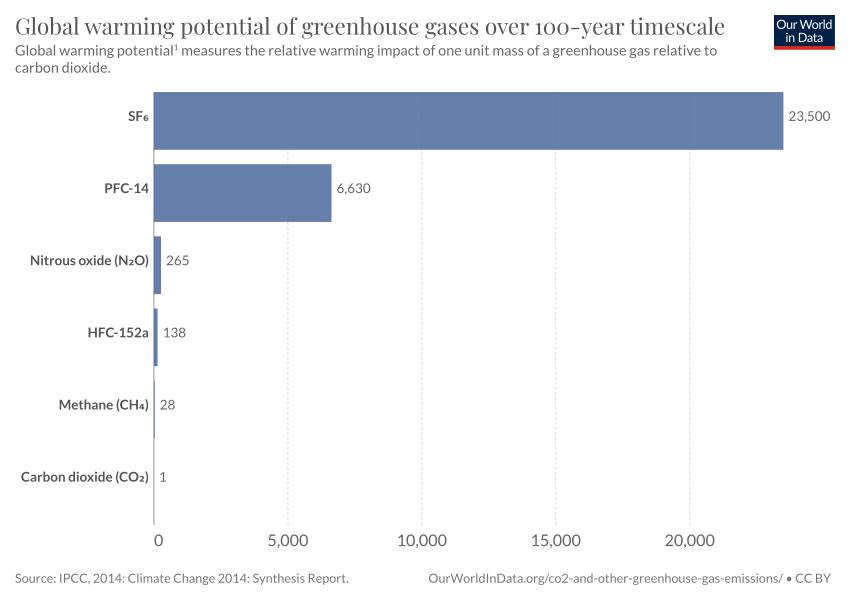

- 지구온난화 잠재력(GWP)은 특정 온실가스가 이산화탄소(CO₂)와 비교하여 얼마나 강력하게 지구 온난화에 기여하는지를 나타내는 지표이다. SF₆의 GWP가 23,500으로 가장 높아, 다른 가스들(PFC-14: 6,630, N₂O: 265, HFC-152a: 138, CH₄: 28, CO₂: 1)을 크게 능가함을 보여준다. 이를 통해, 소량의 고GWP 가스(SF₆ 등)가 CO₂에 비해 지구온난화에 훨씬 큰 영향을 미칠 수 있음을 알 수 있다. Pollutant들의 지구 온난화 잠재력 가중치를 계산하여 머신 러닝 모델에 적용하기로 결정했다.

In [ ]:
# GWP 가중치 계산
df['GWP_CH4'] = df['CH4'] * 28
df['GWP_HFC'] = df['HFC'] * 138
df['GWP_N2O'] = df['N2O'] * 265
df['GWP_PFC'] = df['PFC'] * 6630
df['GWP_SF6'] = df['SF6'] * 23500

# 머신 러닝 모델 적용을 위해 X, y값 나누기
X = df[['GWP_CH4', 'CO2', 'GWP_HFC', 'GWP_N2O', 'GWP_PFC', 'GWP_SF6']]
y = df['Temperature']

# Feature들의 Histogram을 그려 전체적인 데이터의 분포를 확인한다.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Assigning columns to subplots
for ax, column in zip(axes.flatten(),  X.columns):
    ax.hist(df[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.show()

In [ ]:
# 데이터를 시각화해본 결과, 정규 분포를 따르고 있지 않기 때문에 정규화가 필요한 것으로 보여진다.
# 따라서 로그 변환을 통해 진행해본다.

# X값 로그 변환
X[['GWP_CH4', 'CO2', 'GWP_HFC', 'GWP_N2O', 'GWP_PFC', 'GWP_SF6']] = \
np.log1p(X[['GWP_CH4', 'CO2', 'GWP_HFC', 'GWP_N2O', 'GWP_PFC', 'GWP_SF6']])


# Feature들의 Histogram을 그려 전체적인 데이터의 분포를 확인한다.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Assigning columns to subplots
for ax, column in zip(axes.flatten(), X.columns):
    ax.hist(X[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.show()


In [ ]:
# 데이터 로그 스케일링을 통해 배출량 단위 정규화를 한 후 Train_Test_Split을 통해
# 70%, 30%로 학습과 테스트 데이터로 나눈다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=123)

In [ ]:
# Linear Mixed Effects Model (선형혼합효과) 모델
md = smf.mixedlm("Temperature ~ GWP_CH4 + CO2 + GWP_HFC + GWP_N2O + GWP_PFC \
                              + GWP_SF6",
                 data = df, groups = df["Entity"], re_formula = "~Year")
mdf = md.fit()
print(mdf.summary())

In [ ]:
# Assign residual values
residuals = mdf.resid
# Draw Histogram of Residuals
fig, ax = plt.subplots()
ax.hist(residuals, bins = 20)
ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Residuals")

In [ ]:
# Draw Q-Q plot of Residuals
fig, ax = plt.subplots()
sm.qqplot(residuals, line = 's', ax = ax)
ax.set_title("Q-Q Plot of Residuals")
plt.show()

In [ ]:
# 공분산 계산하기
# Group 변수는 매우 큰 변동성을 가지고 있고, Year 변수는 비교적 작은 변동성을 가지고 있다.
# Group과 Year 사이에는 음의 상관관계가 있을 가능성이 있다.
cov_re = mdf.cov_re
print(cov_re)

In [ ]:
# 랜덤 이펙트 출력
random_effects = mdf.random_effects
print(random_effects)

In [ ]:
# 순위 매기기
ranked_group = sorted(random_effects.items(), key = lambda x: x[1]['Group'],
                      reverse = True)
ranked_group

로그 변환을 해본 결과, p-value값이 높게 나오는 현상이 있으며, 모든 변수가 p-value > 0.05로 나왔다.

In [ ]:
# Prediction Error
lr_plot_1 = LinearRegression()
visualizer = PredictionError(lr_plot_1)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [ ]:
# 데이터에 다중공선성이 있을수도 있겠다고 파악된다. 따라서 LASSO와 VIF를 사용해서 다중공선성 유무를
# 판단해본다.

# 라소 회귀 모델 생성 (α 값 수동 설정)
lasso = make_pipeline(Lasso(alpha=0.01))
lasso.fit(X, y)

# 회귀 계수 확인
lasso_coefficients = lasso.named_steps['lasso'].coef_
print("Lasso coefficients:", lasso_coefficients)

# 모델 성능 평가 (R^2 값)
r_squared = lasso.score(X, y)
print(f"R-squared: {r_squared}")

In [ ]:
# 라쏘 회귀 결과, 모든 변수들이 살아 남았지만 계수들의 수치가 이상하게 판단이 된다. 또한 R^2값이
# 좋은 결과가 아니기에 모델이 적합하지 않다고 판단했다.
# 여전히 변수들이 서로 독립적인 관계가 아닐수도 있다고 파악이 된다.
# 따라서 변수들의 VIF(분산 팽창 요인)를 계산하여 변수들의 관계를 확인한다.
# > 10 일경우 다중공선성이 있는 변수로 파악된다.
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 독립 변수만 추출
X_constant = add_constant(df[['GWP_CH4', 'CO2', 'GWP_HFC', 'GWP_N2O',
                              'GWP_PFC', 'GWP_SF6']])

# VIF 계산
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

모델링을 하여 접근해 본 결과, 대부분의 변수들의 p-value 값이 > 0.05로 나타나고 있다. 또한 Linear Regression Model의 R-Squared값을 계산한 결과, 0.380라는 일치하지 못하는 결과가 나왔고, LASSO회귀를 사용해본 결과, R-Squared값이 0.34라는 점수를 기록하며 일치하지 못하는 결과가 나왔다. VIF를 계산해본 결과, 실제로 모든 값들이 > 10의 값을 가지며 이는 다중공선성이 있다고 판단된다. 즉, 선형의 데이터가 아닌것처럼 보여진다. 따라서 PyCaret을 사용하여 어떤 모델이 적합할지 빠르게 파악해보기로 결정하였다.

### PyCaret

In [ ]:
# PyCaret 환경 설정
pycaret_df = df[['GWP_CH4', 'CO2', 'GWP_HFC', 'GWP_N2O', 'GWP_PFC', 'GWP_SF6',
                 'Temperature']]
regression_setup = setup(data=df, target='Temperature', session_id=123, normalize=True)

# 다양한 모델 비교
best_model = compare_models()

# 비교 결과 보기
model_comparison = pull()
print(model_comparison)

#### 결과:
PyCaret을 돌려본 결과, GBM 모델들과, Random Forest 모델이 가장 좋은 성능을 보이는 것으로 파악된다. Gradient Boosting Model의 R^2 값이 큰 차이가 없고, RMSE값도 큰 차이가 없기 때문에, 계산에 빠르고 효율적인 LGBM을 선택했다. 따라서 앙상블 트리 모델인 Random Forest와 Light Gradient Boosting Model로 진행하기로 결정하였다.

### Ensemble Tree Model: Light Gradient Boosting Model

LightGBM은 여러 개의 결정 트리(Decision Trees)를 기반으로 모델을 학습시키며, 특히 대규모 데이터셋과 고차원의 데이터에 대해 효율적이고 빠르게 작동한다.

LGBM을 사용하면 다음과 같은 이점이 있다:
* Gradient Boosting 기반: LightGBM은 Gradient Boosting 알고리즘을 기반으로 작동하는 모델이다. 이 알고리즘은 여러 약한 학습기(주로 결정 트리)를 순차적으로 학습시키며, 각 단계에서 이전 모델의 오류를 줄이도록 새로운 모델을 추가한다.

* 속도와 성능: LightGBM은 대용량 데이터셋에서도 높은 속도로 학습이 가능하며, 메모리 사용량이 적다.

* Leaf-wise 트리 성장: LightGBM은 깊이가 다른 트리 구조를 만들어 내는 Leaf-wise 방식으로 트리를 성장시킨다.

* Handling Imbalanced Data: 불균형 데이터 처리에 유리하며, 이를 통해 클래스 비율이 불균형한 데이터셋에서 좋은 성능을 보일 수 있다.

In [ ]:
# LGBM 모델 셋업
lgbm = LGBMRegressor(n_estimators=50,random_state=0)
lgbm.fit(X_train, y_train)
# 모델 예측
y_pred = lgbm.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# 스코어 출력 및 RMSE 값 출력
print('LGBM Train Score: ',lgbm.score(X_train,y_train))
print('LGBM Test Score: ',lgbm.score(X_test,y_test))
print(f"RMSE: {rmse}")

In [ ]:
# 3. 잔차 계산
residuals = y_test - y_pred

# 4. 잔차 플롯 그리기
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolor='k', alpha=0.6)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [ ]:
# Draw Histogram of Residuals
fig, ax = plt.subplots()
ax.hist(residuals, bins = 20)
ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Residuals")

### Ensemble Tree Model: Random Forest Model

다음으로는 앙상블 트리 모델인 랜덤 포레스트를 적용해본다. 랜덤 포레스트 회귀 모델(Random Forest Regressor)은 앙상블 학습 기법 중 하나로, 여러 개의 결정 트리(Decision Trees)를 결합하여 예측 성능을 향상시키는 모델이다. 각 결정 트리는 독립적으로 학습되고, 이 트리들의 예측 평균을 통해 최종 예측 값을 산출한다. 랜덤 포레스트는 데이터의 부분 샘플링과 특성 샘플링을 통해 다수의 트리를 학습시키고, 이를 앙상블함으로써 과적합(overfitting)을 방지하고 예측의 정확성을 높인다.

이 모델은 높은 비선형성이나 복잡한 상호작용을 가진 데이터에서 우수한 성능을 보이며, 데이터의 노이즈에 강한 특성을 가지고 있다. 또한, 랜덤 포레스트는 모델의 해석 가능성(각 특성의 중요도를 계산하여)을 제공하며, 모델이 자동으로 특성의 중요도를 학습하므로 특성 선택 과정에서 유리하다.

In [ ]:
# 랜덤포레스트 적용
model = RandomForestRegressor(n_estimators=30,random_state=0, oob_score=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('RF Train Score: ',model.score(X_train,y_train))
print('RF Test Score: ',model.score(X_test,y_test))
print(f"RMSE: {rmse}")
print("OOB Score:", model.oob_score_ )

In [ ]:
# 3. 잔차 계산
residuals = y_test - y_pred

# 4. 잔차 플롯 그리기
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolor='k', alpha=0.6)
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [ ]:
# Draw Histogram of Residuals
fig, ax = plt.subplots()
ax.hist(residuals, bins = 20)
ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Residuals")

In [ ]:
# Feature Importance 시각화 함수
def feature_importance_func(importance, name, model_type):
  # Create Arrays from Feature Importance and Names
  feature_importance = np.array(importance)
  feature_names = np.array(name)

  # Create Dataframe using a Dictionary
  data = {'feature_names': feature_names, 'feature_importance': feature_importance}
  fi_df = pd.DataFrame(data)

  # Sort in Descending Order of Feature Importance
  fi_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)

  # Set Figure Size
  plt.figure(figsize = (6, 4))
  # Plot Bar Chart
  sns.set(style = "whitegrid")
  sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'],
              palette = "rocket")
  # Add Labels
  plt.title(model_type + ' FEATURE IMPORTANCE', fontsize = 10)
  plt.xlabel('FEATURE IMPORTANCE', fontsize = 7)
  plt.ylabel('FEATURE NAMES', fontsize = 7)

In [ ]:
# LGBM 피처 중요도 시각화
feature_importance_func(lgbm.feature_importances_,
                        X_train.columns, 'LGBM')

In [ ]:
# Random Forest 피처 중요도 시각화
feature_importance_func(model.feature_importances_,
                         X_test.columns, 'Random Forest')

### **모델링 결론**:

두 모델(Light Gradient Boosting Model과 Random Forest Model)의 성능을 비교한 결과, 각각의 모델은 높은 학습 및 테스트 점수를 기록했지만, Random Forest Model이 약간 더 우수한 성능을 보이는것으로 파악된다.

- **LightGBM**:
  - **Train Score**: 0.9779
  - **Test Score**: 0.9108
  - **RMSE**: 1.8164
  - **결과 분석**: LightGBM 모델은 훈련 데이터에서 높은 점수를 기록했으나, 테스트 데이터에서 약간의 성능 저하가 발생했다. 잔차 플롯과 히스토그램에서는 약간의 비대칭성과 이상값이 보이며, 주요 피처로는 GWP_PFC, GWP_CH4, CO2가 높은 중요도를 가지는것으로 파악된다.

- **Random Forest**:
  - **Train Score**: 0.9904
  - **Test Score**: 0.9548
  - **RMSE**: 1.2940
  - **OOB Score**: 0.9342
  - **결과 분석**: Random Forest 모델은 훈련 데이터와 테스트 데이터 모두에서 높은 점수를 기록하며, LGBM 모델보다 낮은 RMSE를 보여주었다. 잔차 플롯에서는 더 균일한 분포를 보이며, GWP_PFC, GWP_CH4, CO2가 주요 피처로 나타난다.

### 결론
Random Forest 모델은 LightGBM 모델에 비해 테스트 성능이 더 우수하며, 낮은 RMSE와 높은 OOB 점수를 기록하였다. 이는 Random Forest 모델이 주어진 데이터셋에서 더 안정적이고 일반화된 성능을 발휘함을 나타낸다. 두 모델 모두 **PFC, CH4, CO2**가 중요한 피처로 작용하며, 이들 피처가 지구온난화에 큰 영향을 미치는 것으로 해석할 수 있다.
